&nbsp;

# 17 - Mémoire et fermeture markovienne de l'état réduit

---

&nbsp;

## 1. Introduction et objectif

Toujours dans l'optique de nous aiguiller sur la classe de modèles SciML "admissibles", nous pouvons chercher une dernière distinction.

&nbsp;

> #### L'état réduit est-il suffisant pour décrire la dynamique ?

C'est une question fondamentale sur laquelle nous n'avons pas encore tranchée (et sur laquelle on ne peut pas pour le moment).

Répondre à cette question revient à s'interroger sur ce qu'on appelle la fermeture dynamique en étude des systèmes. Étudier la fermeture consiste à chercher des dépendances ou des excitations du système que l'on souhaite approximer. L'hypothèse fondamentale de notre état est qu'il est parfaitement "fermée", soit :

$$
\dot{x}(t) = f(x(t))
$$

Si l'hypothèse d'un défaut de fermeture est admise, donc que le système est présumé dépendant/exciter par quelconques facteurs, alors notre état peut ressembler à :

$$
\text{(1)} \space \dot{x}(t) = f(x(t)) + g(t)
$$

ou :

$$
\text{(2)} \space \dot{x}(t) = f(x(t), x(t-\tau))
$$

ou encore :

$$
\text{(3)} \space \dot{x}(t) = f(x(t), u(t))
$$

De ces possiblités découlent alors une autre interrogation.

&nbsp;

> #### La problème de fermeture est-il de nature temporelle ou structurelle ?

Si le défaut est de nature temporelle alors on émet l'hypothèse que l'état est incomplet dans le temps. Et s'il est incomplet dans le temps, cela ne peut dire qu'une chose que le passé transporte de l'information dynamique, on parle dans ce cas là de *non-markovianité* en témoignage aux processus markoviens décrivant les systèmes ne dépendant pas des valeurs passées pour déterminer les futures. Cela correspond à notre cas $\text{(1)}$ et c'est l'hypothèse que nous allons testé dans ce notebook.

Si ce notebook indique un défaut de fermeture mais invalide l'hypothèse de *non-markovianité*, correspondant à un défaut de fermeture temporel, cela signifie probablement qu'un défaut de fermeture structurel est en cause, les équations $\text{(2)}$ et $\text{(3)}$ dans notre cas. Dans ce scénario nous étudierons cette nouvelle hypothèse dans un nouveau notebook dédié.

&nbsp;

---

&nbsp;

## 2. Autocorrélation des dérivées

L'autocorrélation de $\dot{x}(t)$ est : 

$$
\mathcal{C}_{\dot{x}}(\tau) = \mathbb{E}[\dot{x}(t)\dot{x}(t +\tau)]
$$

C'est la mesure qui décrit l'amplitude de la ressemblance de la dérivée à elle-même parès un décalage temporel $\tau$. Le calcul de cette indicateur rentre tout à fait dans le registre de la réponse que l'on cherche à apporter car on veut tester l'hypothèse de Markovianité. Calculons et discutons des résultats possibles.



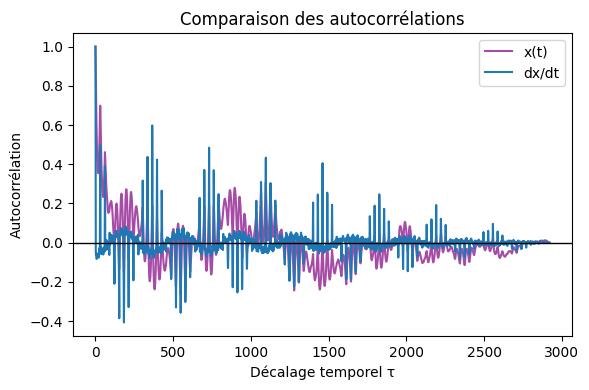

Temps de corrélation de dx/dt : 91.65950926279766
Temps de corrélation de x(t) : 246.39562930111424


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Basic initialization from the latest processed data
data = np.load("data/processed/sstReducedStateCOPERNICUS20102019Prepared.npz")

PCs = data["PCsTrain"]
t   = data["tTrain"]

dt = float(np.mean(np.diff(t))) # We set the time step (for the derivative scale)

x0 = PCs[:, 0]  # initial condition for the first PC

dxDt = np.gradient(x0, dt)  # dérivée temporelle de la première PC

# We remove the mean to focus on fluctuations
dx = dxDt - np.mean(dxDt)

# We compute the autocorrelation function
acfDx = np.correlate(dx, dx, mode="full")
acfDx = acfDx[acfDx.size // 2:]  # keep only non-negative lags
acfDx /= acfDx[0]              # normalize

lags = np.arange(len(acfDx)) * dt # convert to time lags

x0Centered = x0 - np.mean(x0)  # remove mean from the original signal

acfX = np.correlate(x0, x0, mode="full")
acfX = acfX[acfX.size // 2:]
acfX /= acfX[0]

plt.figure(figsize=(6, 4))
plt.plot(lags, acfX, label="x(t)", color="purple", alpha=0.7)
plt.plot(lags, acfDx, label="dx/dt")
plt.axhline(0, color="k", linewidth=1)
plt.xlabel("Décalage temporel τ")
plt.ylabel("Autocorrélation")
plt.legend()
plt.title("Comparaison des autocorrélations")
plt.tight_layout()
plt.show()

# Compute the correlation times via integration of the absolute value of the ACF
# trapezoidal integration : integral where the function is sampled at discrete points
tauCorrDx = np.trapezoid(np.abs(acfDx), lags)
tauCorrX  = np.trapezoid(np.abs(acfX), lags)

print("Temps de corrélation de dx/dt :", tauCorrDx)
print("Temps de corrélation de x(t) :", tauCorrX)



Pour $\dot{x}$, on observe :
- un pic trivial à $\tau = 0$
- une décroissance globale et progressive
- des oscillations persistantes avec alternance de signes
- une amplitude qui diminue lentement

Ce que ça signifie pour nous c'est qu'il existe bien une structure temporelle qui se caractérise par une autocorrélation oscillante (présence d'une composante quasi-oscillatorie donc), ce qui est cohérent voire typique des systèmes dissipatifs. L'information passée finie par être oubliée. Attention cela n'implique automatiquement une mémoire non-markovienne.

La comparaison entre les autocorrélations est l'indice important ici.

Pour faire simple, l'hypothèse d'un système markovien présume qu'il existe une fonction $\mathcal{f}$ telle que :

$$
\dot{x}(t) = f(x(t))
$$

Cela implique donc que la seule variable porteuse du passé est $x(t)$. $\dot{x}(t)$ n'a donc pas de raison d'être corrélé longtemps, celle-ci ne reflète que la persistance de l'état.

Dans un système réel (comme le nôtre), l'autocorrélation ne tombe jamais instantanément à zéro, on ne parle donc pas de *markovianité* mais de *quasi-markovianité* où :

$$
\dot{x}(t) \approx f(x(t))
$$

Dans notre cas, le passé est oublié relativement rapidement. On peut établir cela en comparant deux temps caractéristiques bien distincts comme suit :

$$
\tau_\text{corr}(\dot{x}) \ll \tau_\text{dyn}(x)
$$

où :
- $\tau_\text{corr}(\dot{x})$ : temps au-delà duquel la dérivée n'apporte plus d'information nouvelle
- $\tau_\text{dyn}(x)$ : temps sur lequel l'état évolue significativement

En observant les temps de corrélation calculés avec la méthode *trapezoid()* (calcul d'aire sous la courbe des deux autocorrélations), on constate que cet inégalité est vérifiée ($ 10² \ll 10³$, pas d'inégalité d'échelle très différente mais c'est suffisant).

Ainsi, le système n'est pas strictement markovien et l'hypothèse de non-markovianité n'est pas rejettée, on parle ainsi de *quasi-markovianité*. On considère donc désormais que l'hypothèse $\dot{x}(t) \approx f(x(t))$ est raisonnable.

&nbsp;

---

&nbsp;

## 3. Dépendance explicite à l'état retardé

La nature et le rôle de cette seconde partie dépendent du résultat que nous avons obtenu dans la section précédente. En effet, nous avons déterminé l'hypothèse raisonnable de *quasi-markovianité*, mais une nouvelle interrogation en découle.

> #### Connaître $x(t-\tau)$ apporte-t-il une information conditionnelle supplémentaire une fois $x(t)$ connu ?

Cette question est en fait une instanciation moderne de ce qu'on appelle classiquement les tests de causalités de Granger (de Clive Granger). Cela revient fformellement à se demander si :

$$
\text{Var}(x_t|x_{t-1:t-p}, y_{t-1:t-p}) \geq \text{Var}(x_t|x_{t-1:t-p})
$$

Cette logique est ensuite largement utilisée dans les modèles ARX/ARMAX et les tests de dépendances retardée (notre cas). L'exacte formulation mathématique de notre problématique est en fait la dépendance conditionnelle suivante :

$$
\dot{x}(t) \perp x(t-\tau) \space | \space x(t) \space ?
$$

&nbsp;

> #### Comment fonctionne la méthode de test ?

On compare deux modèles :

- Un modèle sans mémoire

$$
\mathcal{M}_0 : \space \dot{x} = f(x(t)) + \epsilon(t)
$$

- Un modèle avec mémoire

$$
\mathcal{M}_1 : \space \dot{x} = f(x(t), x(t-\tau)) + \epsilon(t)
$$

$\mathcal{M}_0$ appartient à $\mathcal{M}_1$, où toute amélioration de performance serait attribuable uniquement à l'information retardée.

&nbsp;

**1ère étape** : On fixe un retard $\tau$, qu'on exprimera en pas et répète l'analyse pour une plage de $\tau$.

**2ème étape** : On construit les datasets pour les deux modèles et on fixe la cible commune $y = \dot{x}(t)$.

**3ème étape** : On ajuste les deux modèles via régression linéaire, avec les mêmes données où seule la variable supplémentaire change.

**4ème étape** : On compare les performances avec une métrique de qualité d'ajustement ($R²$ ou MSE par exemple).

**5ème étape** : On définit le gain prédictif comme $\Delta$ entre les modèles $\mathcal{M}_0$ et $\mathcal{M}_1$ en fonction de $\tau$.

Nous nous devons d'émettre les quelques limites de la méthode :
- Sensibilité (inévitable) aux petits retards qui ne doit jamais être interprété comme de la mémoire mais comme une information locale intrinsèque à proximité de la valeur de référence. 
- La régression linéaire peut sous-estimer une mémoire non-linéaire.
- Indifférenciation entre mémoire et forçage, d'où l'importance de séparer clairement les deux hypothèses dans notre analyse. 

La méthode est parfaitement légitime dans notre projet, appliquons la donc pour trouver une preuve pertinente pour répondre à notre hypothèse.

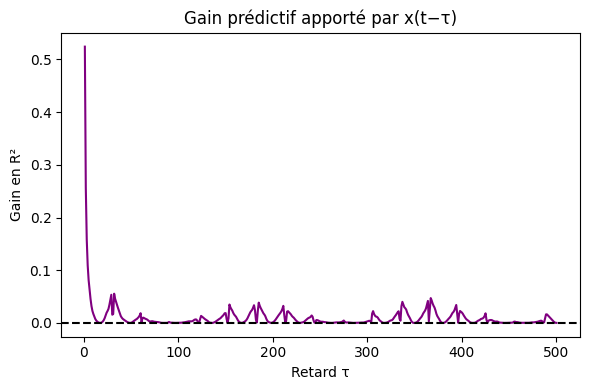

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# We implement a method to quantify the predictive gain brought by the past values x(t-τ)
# See more about this method in Introduction to Time Series and Forecasting — Brockwell & Davis, ARX linear models and delayed regression chapter

taus = np.arange(1, 501, 1)  # lags to test (in number of time steps)
r2NoMemory = []
r2WithMemory = []

xNow = x0Centered
dxNow = dx

for tau in taus:
    xLag = np.roll(xNow, tau)

    valid = np.arange(tau, len(xNow))  # indices of valid points (to avoid wrap-around)
    XNow = xNow[valid].reshape(-1, 1)
    XLag = xLag[valid].reshape(-1, 1)
    dX = dxNow[valid]

    model0 = LinearRegression().fit(XNow, dX)
    pred0 = model0.predict(XNow)
    r20 = r2_score(dX, pred0)

    XFull = np.hstack([XNow, XLag])
    model1 = LinearRegression().fit(XFull, dX)
    pred1 = model1.predict(XFull)
    r21 = r2_score(dX, pred1)

    r2NoMemory.append(r20)
    r2WithMemory.append(r21)

gain = np.array(r2WithMemory) - np.array(r2NoMemory)

plt.figure(figsize=(6, 4))
plt.plot(taus * dt, gain, color="purple")
plt.axhline(0, color="k", linestyle="--")
plt.xlabel("Retard τ")
plt.ylabel("Gain en R²")
plt.title("Gain prédictif apporté par x(t−τ)")
plt.tight_layout()
plt.show()



Bingo ! On observe qu'avec un très petit retard ($\tau = 1-3$) le gain est très élevé (~$0.5$ en R²). Mais dès que l'on sort de l'échelle locale ($\tau \geq 5$) et qu'on atteint des retards intermédiaires à longs, le gain prédictif s'effondre avec de petits renflements locaux et ponctuels.

&nbsp;

> #### Qu'est-ce que cela nous apprend ?

Cela nous indique qu'une fois que l'état courant est connu, le passé n'apporte quasiment rien.

Le modèle "avec mémoire" triche légèrement car il récupère une information locale mais dans notre cas, ça ne correspond probablement pas à une mémoire dynamique, d'où le gain élevé à retard très petit. À ce stade, on considère le critère de fermeture markovienne effective validé et l'état *quasi-fermé*.

Les quelques renflements ponctuels sont probablement des trace de quasi-périodicité ou à un résidu de structure oscillante. Même si on établit l'hypothèse que cela pourrait correspondre un artefact concret de mémoire dynamique, c'est trop faible pour exploiter quelconque valeur pour notre modélisation SciML. Ces pics ne remettent pas en cause la conclusion markovienne.

&nbsp;

Pour répondre concrètement à la problèmatique on affirme désormais que connaître $x(t-\tau)$ n'apporte d'informations supplémentaire à $x(t)$ connu (ou trop peu). Néanmoins, un système peut être markovien tout en dépendant d'un forçage, d'un paramètre latent ou d'une dynamique lente (correspondant aux cas $(2)$ et $(3)$). 

En conclusion, on peut dire l'hypothèse que $\dot{x}(t) \approx f(x(t))$ est toujours raisonnable. Le test de forçages ou de paramètres latents revient à poser l'hypothèse que le modèle échouera "plus" pour des raisons structurelles, si tel est le cas nous le remarquerons par des erreurs systèmatiques, si tel est le cas, nous investigerons au moment de la découverte de preuves. Nous pouvons désormais nous diriger vers l'implémentation de premiers modèles ML. 

